In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

Here is some utility functions that would help us during the EDA:

In [2]:
def get_img_dimensions(img_path):
    with Image.open(img_path) as img:
        return img.size

def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)

    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1

    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width, height):
    mask = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        mask += rle_to_mask(startP, lengthP, width, height)
    return mask

def calc_mask_size(pixelStr: str):
    if (pixelStr == pixelStr):
        split = pixelStr.split(" ")
        lengthP = np.array(split[1::2], dtype=int)
        return lengthP.sum()
    else:
        return 0


In [3]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

In [4]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
display(df.head(10))
display(df.describe())

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


Our dataset consists from 2 colums: ImageId and EncodedPixels. As we see, the ImageId column contains a repeating image names. Since the dataset description says that some images have multiple ships, my assumption is that EncodedPixels column contains a mask for a single ship per image, so if the image has N numer of ships - it would have N number of records in our dataset. To check this - lets display the images and corresponding masks for first 10 images (to do this we would use utility function defined at the begining of this notebook).

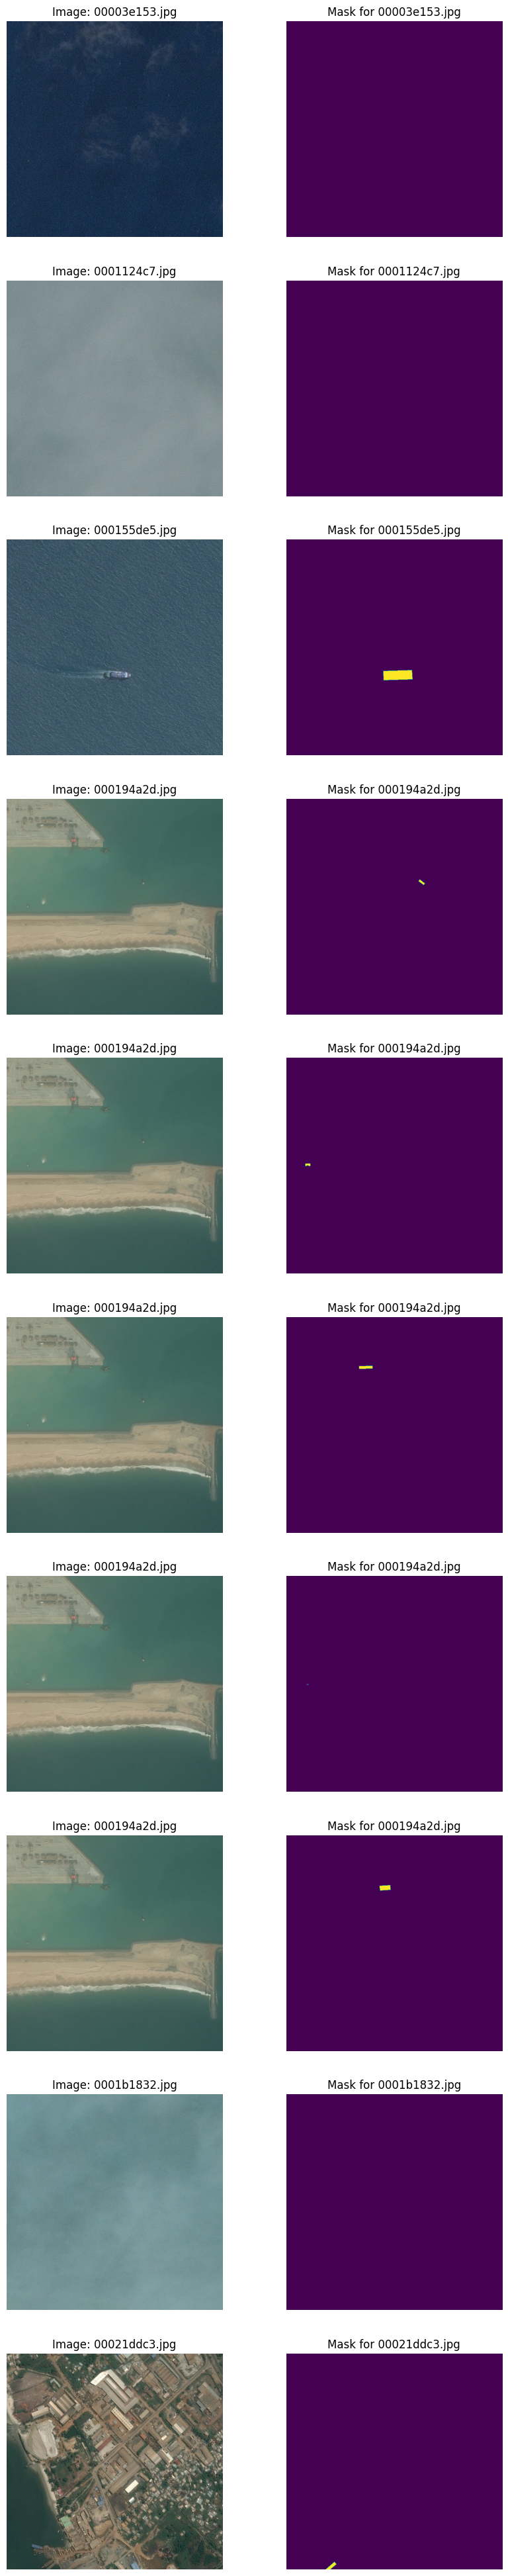

In [5]:
fig, ax = plt.subplots(10,2 , figsize=(10, 50))

# Select first 10 images
img_names = df['ImageId'].head(10)
img_masks = df['EncodedPixels'].head(10)

for i in range(len(img_names)):
    img = Image.open(os.path.join(TRAIN_IMG_DIR, img_names.loc[i]))
    ax[i,0].imshow(img)
    width, height = img.size
    ax[i,1].imshow(create_mask(img_masks.loc[i],width,height))
    ax[i, 0].set_title(f'Image: {img_names.loc[i]}')
    ax[i, 1].set_title(f'Mask for {img_names.loc[i]}')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')


The assumption was correct: the duplicates of ImageIds indicate that the image has multiple ships present at it.
Lets create a countplot to check the distribution between empty vs non-empty images.
But before we do this, we would add column "has_ship" to make dataset manipulations easier.

Number of images with ships - 150000
Number of images withput ships - 42556
Empty to non-empty ratio - 3.5247673653538865


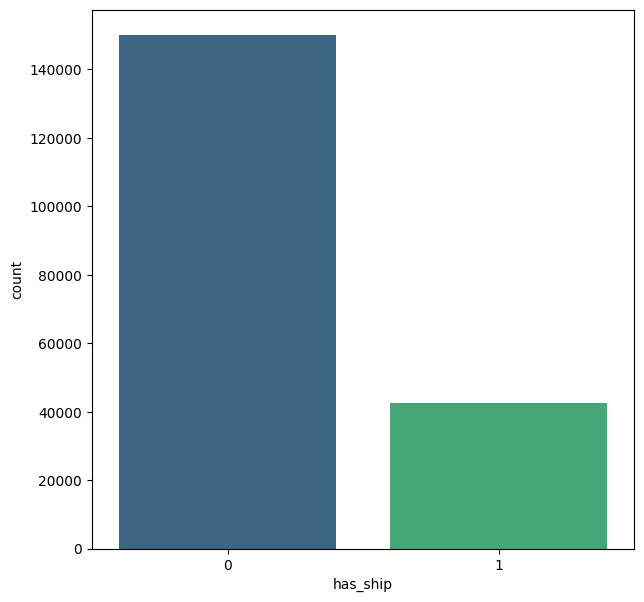

In [6]:
# Add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# Plot the chart, and drop repeating ImageIds since we are interested in number of images, not in total number of ships in the dataset
plt.figure(figsize=(7, 7))
sns.countplot(x='has_ship', data=df.drop_duplicates(subset='ImageId', keep='first'), palette='viridis')

# Calculate number of empty and non empty images
num_empty = len(df[df['has_ship'] == 0])
num_non_empty = len(df.drop_duplicates(subset='ImageId', keep='first')[df['has_ship'] != 0])

print(f"Number of images with ships - {num_empty}")
print(f"Number of images withput ships - {num_non_empty}")
print(f"Empty to non-empty ratio - {num_empty/num_non_empty}")

We see, that our dataset is highly imbalanced, the number of empty images is 3.5 times higher than non-empty. When preparing training set this should be kept in mind.
Next, lets calculate the area of each mask represented by the EncodedPixels, find the dimensions of each image and create a column "mask_size_percentage", so we would be able to anlalyse what percantage of the image the mask takes.

In [7]:
df['mask_size'] = df['EncodedPixels'].apply(lambda x: calc_mask_size(x))

The code in the next cell requires a lot of time to finish because it is an hdd read operation. After execution of these code it was discovered, that all images are 768x768 pixels. To speed up the execution of this notebook the next cell would be commented out and instead of reading file size every time from storage, we would manually add this information to the dataframe.

In [8]:
df['width'], df['height'] = zip(*df['ImageId'].apply(lambda x: get_img_dimensions(os.path.join(TRAIN_IMG_DIR, x))))


In [9]:
df.to_csv('dataset_with_image_dims', index=False)

In [10]:
# df[width] = 768
# df[height] = 768

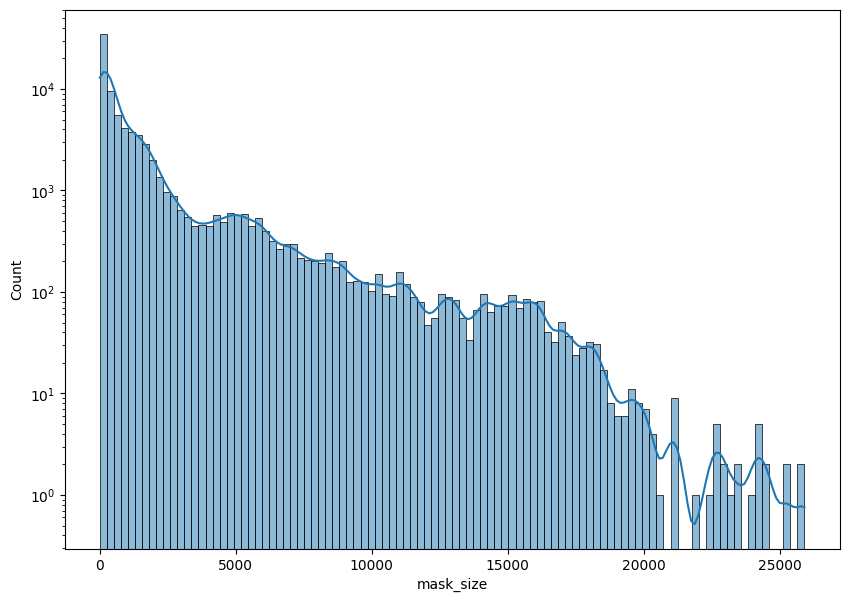

In [11]:
df_nonempty = df[df['has_ship'] != 0]

plt.figure(figsize=(10, 7))
ax = sns.histplot(df_nonempty['mask_size'], bins=100, kde=True)
ax.set_yscale('log')


!!!From the histogram above we see that in our dataset the smaller ships masks prevail over the big one. The mask sizes should also be considered during preparation of the training dataset

In [12]:
# df_small = df.sample(len(df)//100)
# df_small['width'], df_small['height'] = zip(*df_small['ImageId'].apply(lambda x: get_img_dimensions(os.path.join(TRAIN_IMG_DIR, x))))
# display(df_small.describe())

In [13]:
# df['width'], df['height'] = zip(*df['ImageId'].apply(lambda x: get_img_dimensions(os.path.join(TRAIN_IMG_DIR, x))))
# df['img_size'] = df['ImageId'].apply(lambda x: get_img_dimensions(os.path.join(TRAIN_IMG_DIR, x)))


In [14]:
# display(df)

In [15]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)

# add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# add info about total number of ships at the image
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# concat EncodedPixels tp AllEncodedPixels
df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# remove repeating images
df = df.drop_duplicates(subset='ImageId', keep='first')

# delete EncodedPixels column
df = df.drop(columns=['EncodedPixels'])

# reset indexes
df = df.reset_index(drop=True)